In [ ]:
!wget "https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz"
!wget "https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz"

--2022-11-22 07:00:39--  https://thor.robots.ox.ac.uk/~vgg/data/pets/images.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 791918971 (755M) [application/octet-stream]
Saving to: ‘images.tar.gz.1’

images.tar.gz.1     100%[===================>] 755.23M   206MB/s    in 3.8s    

2022-11-22 07:00:43 (200 MB/s) - ‘images.tar.gz.1’ saved [791918971/791918971]

--2022-11-22 07:00:43--  https://thor.robots.ox.ac.uk/~vgg/data/pets/annotations.tar.gz
Resolving thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)... 129.67.95.98
Connecting to thor.robots.ox.ac.uk (thor.robots.ox.ac.uk)|129.67.95.98|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/octet-stream]
Saving to: ‘annotations.tar.gz.1’

annotations.tar.gz. 100%[===================>]  18.28M  --.-KB/s    in 0.1s    

2022-1

In [ ]:
!tar -xzvf "./annotations.tar.gz" -C "./"
!tar -xzvf "./images.tar.gz" -C "./"

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
images/american_bulldog_194.jpg
images/Birman_175.jpg
images/american_bulldog_178.jpg
images/staffordshire_bull_terrier_93.jpg
images/Egyptian_Mau_58.jpg
images/havanese_44.jpg
images/english_cocker_spaniel_97.jpg
images/Ragdoll_111.jpg
images/american_pit_bull_terrier_159.jpg
images/english_setter_134.jpg
images/english_setter_87.jpg
images/wheaten_terrier_198.jpg
images/pug_180.jpg
images/boxer_172.jpg
images/Sphynx_197.jpg
images/german_shorthaired_2.jpg
images/British_Shorthair_9.jpg
images/pug_89.jpg
images/japanese_chin_39.jpg
images/Ragdoll_20.jpg
images/american_bulldog_111.jpg
images/yorkshire_terrier_112.jpg
images/Persian_88.jpg
images/pug_9.jpg
images/Birman_40.jpg
images/British_Shorthair_272.jpg
images/havanese_7.jpg
images/pomeranian_154.jpg
images/beagle_49.jpg
images/British_Shorthair_94.jpg
images/Persian_90.jpg
images/staffordshire_bull_terrier_30.jpg
images/samoyed_113.jpg
images/english_cocker_spaniel_46.jpg
images/Abyssinian_22.

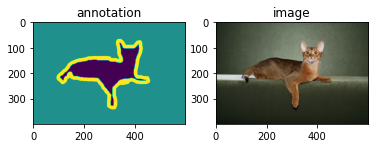

In [ ]:
import matplotlib.pyplot as plt # 시각화

from PIL import Image # 이미치 처리 라이브러리

# 우클릭 > 속성 > 위치 > 예시) C:\Users\Playdata\Downloads
# > /annotations/trimaps (annotation)
# > /images (image)
path_to_annotation = "./annotations/trimaps"
path_to_image = "./images"

# 이미지 불러오기
annotation = Image.open(f"{path_to_annotation}/Abyssinian_1.png")
plt.subplot(1, 2, 1)
plt.title("annotation")
plt.imshow(annotation)

image = Image.open(f"{path_to_image}/Abyssinian_1.jpg")
plt.subplot(1, 2, 2)
plt.title("image")
plt.imshow(image)

plt.show()

In [ ]:
# 이미지 묶음 -> Dataset 객체 -> 초기화 (생성자)
# 1. 정렬 : 정답/입력 - 다른 경로 => 짝을 지어서 (이름순으로 정렬)
# 2. 정답(라벨) -> 학습난이도. 동물 : 0 / 경계 : 1 / 배경 : 2 -> 경계+동물

# 데이터셋 만들기
import glob # 이미지 파일 특정한 규칙을 통해 불러올 때
import torch
import numpy as np

In [ ]:
from torch.utils.data.dataset import Dataset
from PIL import Image

In [ ]:
class Pets(Dataset):
    def __init__(self, path_to_img,
                 path_to_anno,
                train=True, transforms=None,
                input_size=(128, 128)):
        
        # 정답과 입력 이미지를 이름순(영어 오름차순)으로 정리
        self.images = sorted(glob.glob(f"{path_to_img}/*.jpg"))
        self.annotations = sorted(glob.glob(f"{path_to_anno}/*.png"))
        
        # 데이터셋 -> 학습/평가용 (80% 학습용. 20% 평가용)
        # 100
        print(f"images : {len(self.images)}")
        self.X_train = self.images[:int(0.8 * len(self.images))]
        # self.image[:80] 0-79
        self.X_test = self.images[int(0.8 * len(self.images)):]
        # self.image[80:] 80-99
        print(f"annotations : {len(self.annotations)}")
        self.Y_train = self.annotations[:int(0.8 * len(self.annotations))]
        self.Y_test = self.annotations[int(0.8 * len(self.annotations)):]
        
        self.train = train
        self.transforms = transforms
        self.input_size = input_size
    
    def __len__(self): # len(...)
        if self.train:
            return len(self.X_train) # 학습용 데이터셋의 길이
        else:
            return len(self.X_test) # 평가용 데이터셋의 길이
    
    # 정답을 다중분류->이진분류
    def preprocess_mask(self, mask):
        # mask : 동물(0), 경계(1), 배경(2)을 담은 annotation 파일
        mask = mask.resize(self.input_size) # image의 크기 -> 리사이징
        mask = np.array(mask).astype(np.float32) # numpy -> float32 (0.0, 1.0, 2.0)
        # [0, 0, 0, 0...] [1, 2, 0.....]
#         print(mask)
        # 2 : 배경인지
        mask[mask != 2.0] = 1.0 # 배경 X -> 본체, 경계 (1)
        mask[mask == 2.0] = 0.0 # 배경 0 -> (0)
        mask = torch.tensor(mask)
        return mask

    # 이미지를 읽어들인다음 데이터 증강 후 반환 함수
    def __getitem__(self, i): # i번째 데이터와 정답을 반환
        if self.train : # 학습용 데이터
            X_train = Image.open(self.X_train[i]).convert('RGB')
            X_train = self.transforms(X_train)
            Y_train = Image.open(self.Y_train[i])
            Y_train = self.preprocess_mask(Y_train)
            
            return X_train, Y_train
        
        else: # 평가용 데이터
            X_test = Image.open(self.X_test[i])
            X_test = self.transforms(X_test)
            Y_test = Image.open(self.Y_test[i])
            Y_test = self.preprocess_mask(Y_test)
            
            return X_test, Y_test

In [ ]:
# 모델 정의
import torch.nn as nn

class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        
        # (1) U-Net 인코더에 사용되는 은닉층
        # 128px x 128px
        # 기본 블록
        self.enc1_1 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.enc1_2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 64
        enc = lambda x, y: nn.Conv2d(x, y, kernel_size=3, padding=1)
        self.enc2_1 = enc(64, 128)
        self.enc2_2 = enc(128, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 32
        self.enc3_1 = enc(128, 256)
        self.enc3_2 = enc(256, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 16
        self.enc4_1 = enc(256, 512)
        self.enc4_2 = enc(512, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)
        # 8 => 8px
        # --- 
        # 인코더의 마지막 기본 블록
        self.enc5_1 = enc(512, 1024)
        self.enc5_2 = enc(1024, 512)
        # 풀링 X
        
        # (2) 디코더
        self.upsample4 = nn.ConvTranspose2d(512, 512, 2, stride=2)
        # 2 겹쳐짐 -> 1024 
        dec = lambda x, y: nn.Conv2d(x, y, kernel_size=3, padding=1)
        self.dec4_1 = dec(1024, 512)
        self.dec4_2 = dec(512, 256)
        
        self.upsample3 = nn.ConvTranspose2d(256, 256, 2, stride=2)
        self.dec3_1 = dec(512, 256)
        self.dec3_2 = dec(256, 128)
        
        self.upsample2 = nn.ConvTranspose2d(128, 128, 2, stride=2)
        self.dec2_1 = dec(256, 128)
        self.dec2_2 = dec(128, 64)
        
        self.upsample1 = nn.ConvTranspose2d(64, 64, 2, stride=2)
        self.dec1_1 = dec(128, 64)
        self.dec1_2 = dec(64, 64)
        self.dec1_3 = nn.Conv2d(64, 1, kernel_size=1)
        
        # 활성화 함수
        self.relu = nn.ReLU()
        
    def forward(self, x):
        # 인코더의 순전파
        x = self.enc1_1(x)
        x = self.relu(x)
        e1 = self.enc1_2(x) # 디코더에서 사용 (like x_)
        e1 = self.relu(e1) # 인코더 은닉층1을 거친 값
        x = self.pool1(e1)
        
        x = self.enc2_1(x)
        x = self.relu(x)
        e2 = self.enc2_2(x) # 디코더에서 사용 (like x_)
        e2 = self.relu(e2) # 인코더 은닉층2을 거친 값
        x = self.pool2(e2)
        
        x = self.enc3_1(x)
        x = self.relu(x)
        e3 = self.enc3_2(x) # 디코더에서 사용 (like x_)
        e3 = self.relu(e3) # 인코더 은닉층3을 거친 값
        x = self.pool3(e3)
        
        x = self.enc4_1(x)
        x = self.relu(x)
        e4 = self.enc4_2(x) # 디코더에서 사용 (like x_)
        e4 = self.relu(e4) # 인코더 은닉층4을 거친 값
        x = self.pool4(e4)
        
        x = self.enc5_1(x) # 512, 1024
        x = self.relu(x) 
        x = self.enc5_2(x) # 1024, 512, 8px
        x = self.relu(x) # 사이즈 512
        
        # 디코더의 순전파
        x = self.upsample4(x)
        # 인코더의 출력 + 업샘플링 합침
        x = torch.cat([x, e4], dim=1)
        x = self.dec4_1(x)
        x = self.relu(x)
        x = self.dec4_2(x)
        x = self.relu(x)
        
        x = self.upsample3(x)
        # 인코더의 출력 + 업샘플링 합침
        x = torch.cat([x, e3], dim=1)
        x = self.dec3_1(x)
        x = self.relu(x)
        x = self.dec3_2(x)
        x = self.relu(x)
        
        x = self.upsample2(x)
        # 인코더의 출력 + 업샘플링 합침
        x = torch.cat([x, e2], dim=1)
        x = self.dec2_1(x)
        x = self.relu(x)
        x = self.dec2_2(x)
        x = self.relu(x)
        
        x = self.upsample1(x)
        # 인코더의 출력 + 업샘플링 합침
        x = torch.cat([x, e1], dim=1)
        x = self.dec1_1(x)
        x = self.relu(x)
        x = self.dec1_2(x)
        x = self.relu(x)
        # 특징 -> 복구
        x = self.dec1_3(x) # 사이즈를 맞춰주기 위한 디코딩
        
        x = torch.squeeze(x) # 흑백 이미지를 그림 (값이 1인 차원을 제거)
        
        return x

In [ ]:
from tqdm.notebook import tqdm

from torchvision.transforms import Compose
from torchvision.transforms import ToTensor, Resize
from torch.optim.adam import Adam
from torch.utils.data.dataloader import DataLoader

device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

# 데이터 전처리 정의
transforms = Compose([
    Resize((128, 128)),
    ToTensor()
])

cuda


In [ ]:
train_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transforms)

test_set = Pets(path_to_img=path_to_image,
                 path_to_anno=path_to_annotation,
                 transforms=transforms,
               train=False)

train_loader = DataLoader(train_set, batch_size=32, shuffle=True)
test_loader = DataLoader(test_set)

images : 7390
annotations : 7390
images : 7390
annotations : 7390


In [ ]:
# 모델 정의
model = UNet().to(device)

# 학습률 정의
learning_rate = 0.0001 # 일반적으로 0.001 ~ 0.00001 사이로 사용

# 최적화 정의
optim = Adam(params=model.parameters(), lr=learning_rate)

In [ ]:
for epoch in range(200):
    iterator = tqdm(train_loader)
    
    for data, label in iterator:
        optim.zero_grad()
        preds = model(data.to(device))
    
        loss = nn.BCEWithLogitsLoss()(
            preds,
            label.type(torch.FloatTensor).to(device))
        loss.backward()
    
        optim.step()
        iterator.set_description(f"epoch{epoch+1} loss:{loss.item()}")

torch.save(model.state_dict(), "./UNet.pth")

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]

  0%|          | 0/185 [00:00<?, ?it/s]